In [ ]:
import pandas as pd
import numpy as np
import math

path_norm = 'data/norm/dataset/csv/papers.csv'   
path_pred = 'data/pred/dataset/csv/papers.csv'   
PRE_END  = 2021
POST_BEG, POST_END = 2022, 2024
def base_df(path, encoding=None):
    df = pd.read_csv(path, encoding=encoding)  
    df = df.dropna(subset=['publication_date', 'authors']).copy()
    df['year'] = (
        df['publication_date'].astype(str)
        .str.extract(r'(\d{4})', expand=False)
        .astype(float)
    )
    df = df.dropna(subset=['year']).copy()
    df['year'] = df['year'].astype(int)
    return df


<h1>Part 1: Single Author</h1>

Single Author z-test

In [39]:
def normalize_delimiters(s: str) -> str:
    s = str(s)
    s = s.replace(';', ',')
    s = s.replace(' and ', ',')
    s = s.replace('，', ',')
    s = ','.join([t.strip() for t in s.split(',') if t.strip()!=''])
    return s

def overall_single_author(path):
    df = base_df(path).copy()  
    df['authors'] = df['authors'].apply(normalize_delimiters)
    df['author_count'] = df['authors'].str.split(',').apply(len)
    n = len(df)
    x = int((df['author_count'] == 1).sum())
    p = x / n if n > 0 else np.nan
    return n, x, p

def extract_year(series):
    y = series.astype(str).str.extract(r'(\d{4})', expand=False)
    y = pd.to_numeric(y, errors='coerce')
    return y.dropna().astype(int)

def period_single_author(path, period: str):
    assert period in ('pre','post')
    df = pd.read_csv(path)
    df = df.dropna(subset=['authors', 'publication_date']).copy()
    df['year'] = extract_year(df['publication_date'])
    df = df.dropna(subset=['year']).copy()
    df['year'] = df['year'].astype(int)
    if period == 'pre':
        df = df[df['year'] <= PRE_END]
    else:
        df = df[(df['year'] >= POST_BEG) & (df['year'] <= POST_END)]
    df['authors'] = df['authors'].apply(normalize_delimiters)
    df['author_count'] = df['authors'].str.split(',').apply(len)
    n = len(df)
    x = int((df['author_count'] == 1).sum())
    p = x / n if n > 0 else np.nan
    return n, x, p

def ztest_2prop(x1,n1,x2,n2,alternative='two-sided'):
    if n1==0 or n2==0: return np.nan, np.nan
    p1, p2 = x1/n1, x2/n2
    p_pool = (x1+x2)/(n1+n2)
    se = math.sqrt(p_pool*(1-p_pool)*(1/n1 + 1/n2))
    if se==0: return np.nan, np.nan
    z = (p1-p2)/se
    cdf = 0.5*(1 + math.erf(z/math.sqrt(2)))
    if alternative=='two-sided':
        p = 2*(1 - 0.5*(1 + math.erf(abs(z)/math.sqrt(2))))
    elif alternative=='larger':
        p = 1 - cdf
    else:
        p = cdf
    return z, p

def cohen_h(p1,p2):
    return 2*(math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p2)))

def print_block(title, s_pred, s_norm, alt='larger'):
    n1,x1,p1 = s_pred
    n2,x2,p2 = s_norm
    z,p = ztest_2prop(x1,n1,x2,n2,alternative=alt)
    h = cohen_h(p1,p2) if (n1>0 and n2>0) else np.nan
    print(f"\n=== {title} ===")
    print(f"Predatory: n={n1:,}, single={x1:,}, p={p1:.2%}")
    print(f"Normal   : n={n2:,}, single={x2:,}, p={p2:.2%}")
    print(f"z = {z:.3f}, p = {p:.3g}  (alt='{alt}')")
    print(f"Cohen's h = {h:.3f}")

overall_norm = overall_single_author(path_norm)
overall_pred = overall_single_author(path_pred)
print_block("Overall (match original cleaning: authors only)", overall_pred, overall_norm)

pre_norm  = period_single_author(path_norm, 'pre')
pre_pred  = period_single_author(path_pred, 'pre')
print_block(f"Pre-LLM (≤{PRE_END})", pre_pred, pre_norm)

post_norm = period_single_author(path_norm, 'post')
post_pred = period_single_author(path_pred, 'post')
print_block(f"Post-LLM ({POST_BEG}–{POST_END})", post_pred, post_norm)



=== Overall (match original cleaning: authors only) ===
Predatory: n=5,788, single=716, p=12.37%
Normal   : n=6,180, single=308, p=4.98%
z = 14.437, p = 0  (alt='larger')
Cohen's h = 0.269

=== Pre-LLM (≤2021) ===
Predatory: n=437, single=84, p=19.22%
Normal   : n=846, single=48, p=5.67%
z = 7.570, p = 1.87e-14  (alt='larger')
Cohen's h = 0.427

=== Post-LLM (2022–2024) ===
Predatory: n=5,349, single=632, p=11.82%
Normal   : n=4,916, single=247, p=5.02%
z = 12.283, p = 0  (alt='larger')
Cohen's h = 0.250


Stratifying by year and topic

/home/yuying/miniconda3/envs/new_scholar/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
/tmp/ipykernel_347796/2498295264.py:122: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_sig_A_larger_B = res.pivot(index='topic', columns='period', values='sig_A_larger_B').reindex(columns=periods).fillna(False).astype(bool)
/tmp/ipykernel_347796/2498295264.py:123: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_sig_B_larger_A = res.pivot(index='topic', columns

Sample sizes for A (n):
period  ≤2015  2016  2017  2018  2019  2020  2021  2022   2023   2024
topic                                                                
0.0       0.0   0.0   0.0   0.0   2.0   0.0   1.0   9.0    7.0   74.0
1.0       4.0   NaN   4.0   NaN   4.0   0.0  11.0  15.0   86.0  861.0
10.0      1.0   NaN   NaN   NaN   NaN   0.0   1.0   3.0    8.0   44.0
11.0      NaN   NaN   NaN   NaN   0.0   1.0   2.0   1.0    9.0   34.0
12.0      9.0   1.0   3.0   1.0   9.0   7.0   7.0  15.0   50.0   66.0
13.0      0.0   NaN   1.0   NaN   1.0   2.0   1.0   1.0   40.0  297.0
14.0      2.0   2.0   4.0   4.0   2.0   3.0   3.0  40.0   56.0   63.0
15.0     24.0   7.0   8.0   6.0   7.0   8.0  10.0   8.0   27.0   48.0
16.0      NaN   NaN   NaN   NaN   0.0   0.0   0.0   3.0    9.0   43.0
17.0      2.0   1.0   3.0   1.0   NaN   1.0   4.0   4.0   36.0  110.0
18.0      0.0   NaN   NaN   1.0   0.0   1.0   1.0   3.0    5.0   34.0
19.0      1.0   NaN   NaN   NaN   0.0   0.0   0.0   2.0   10.0   9

/tmp/ipykernel_347796/2498295264.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


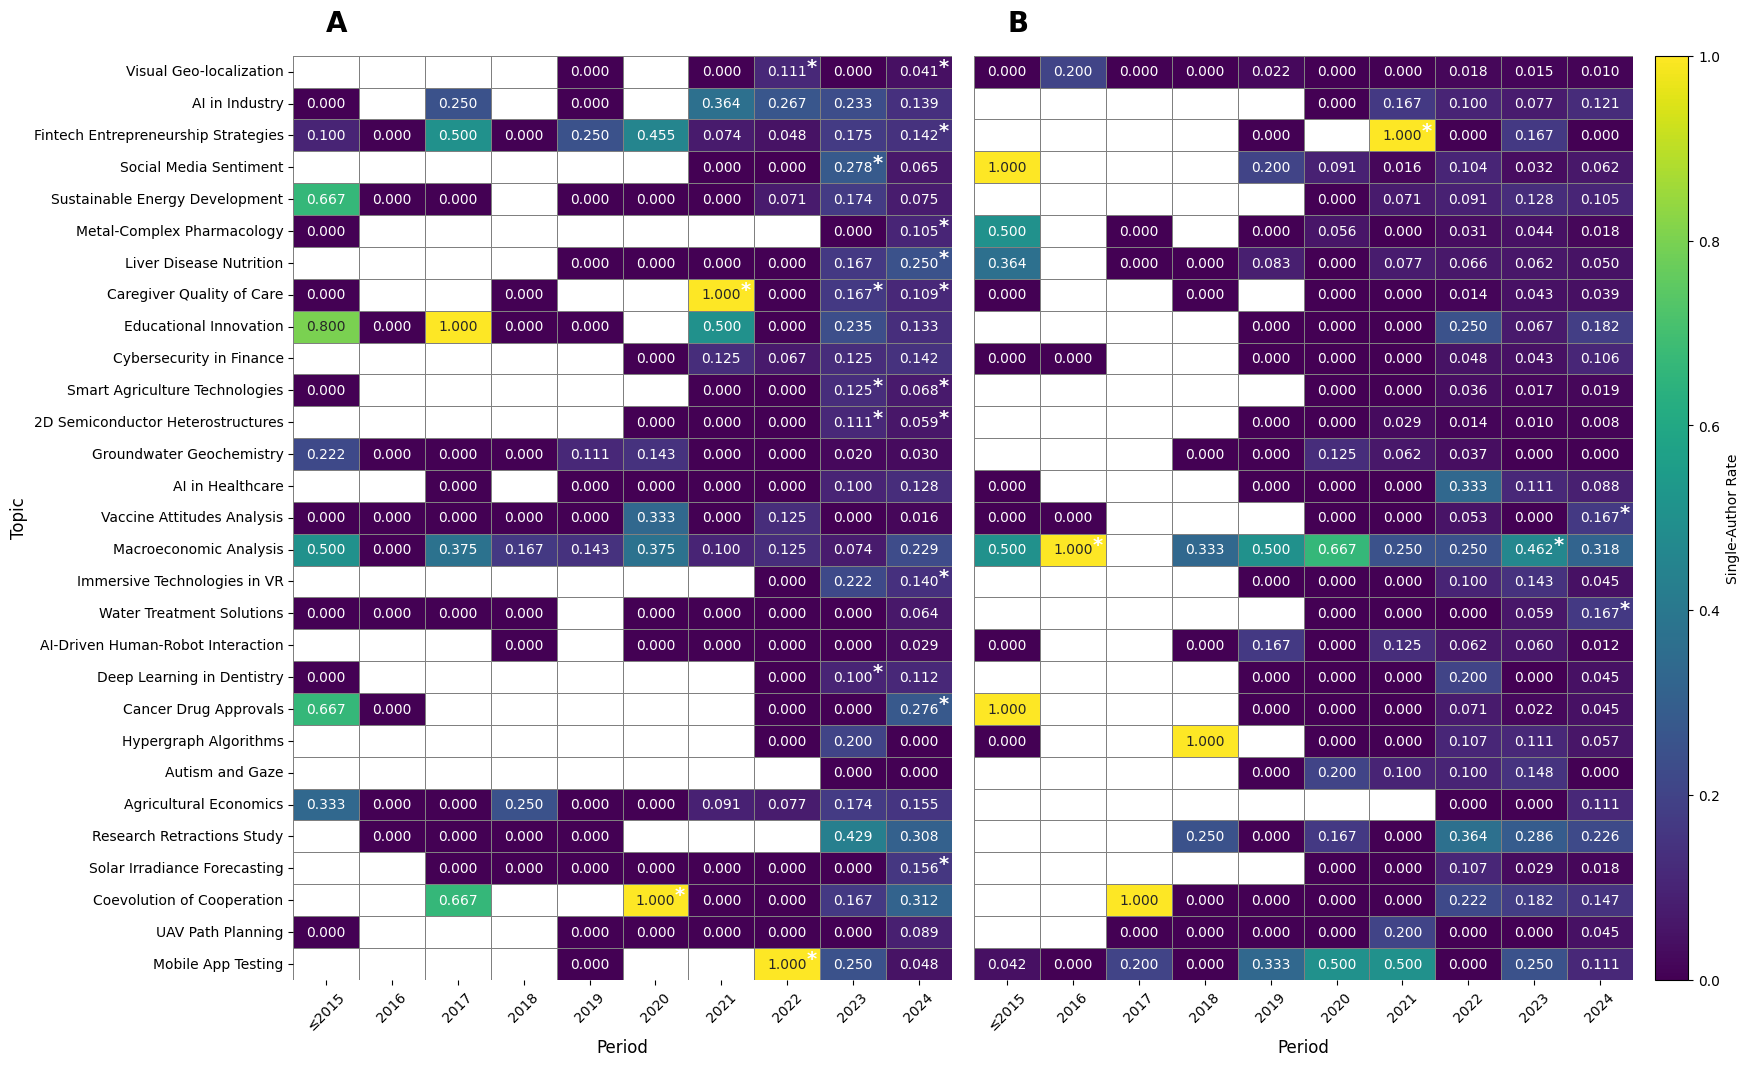

In [36]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.gridspec as gridspec

# 1) Define the topic mapping from ID to name
topic_map = {
    0: 'Visual Geo-localization',
    1: 'AI in Industry',
    2: 'Fintech Entrepreneurship Strategies',
    3: 'Social Media Sentiment',
    4: 'Sustainable Energy Development',
    5: 'Metal-Complex Pharmacology',
    6: 'Liver Disease Nutrition',
    7: 'Caregiver Quality of Care',
    8: 'Educational Innovation',
    9: 'Cybersecurity in Finance',
    10: 'Smart Agriculture Technologies',
    11: '2D Semiconductor Heterostructures',
    12: 'Groundwater Geochemistry',
    13: 'AI in Healthcare',
    14: 'Vaccine Attitudes Analysis',
    15: 'Macroeconomic Analysis',
    16: 'Immersive Technologies in VR',
    17: 'Water Treatment Solutions',
    18: 'AI-Driven Human-Robot Interaction',
    19: 'Deep Learning in Dentistry',
    20: 'Cancer Drug Approvals',
    21: 'Hypergraph Algorithms',
    22: 'Autism and Gaze',
    23: 'Agricultural Economics',
    24: 'Research Retractions Study',
    25: 'Solar Irradiance Forecasting',
    26: 'Coevolution of Cooperation',
    27: 'UAV Path Planning',
    28: 'Mobile App Testing'
}

# 2) Map years to a period
def map_period(year):
    if year <= 2015:
        return '≤2015'
    if 2015 <= year <= 2024:
        return str(year)
    return None

# 3) Calculate single-author statistics for each topic and period
def compute_single_topic_period(path, prefix):
    df = pd.read_csv(path, encoding='latin1')
    
    df = df[df['topic_title_abs_30'] != -1.0].copy()
    df = df.dropna(subset=['topic_title_abs_30'])
    
    df = df.dropna(subset=['authors'])
    df['topic'] = df['topic_title_abs_30'].astype(str).str.strip()
    df['year'] = pd.to_numeric(
        df['publication_date'].astype(str).str.extract(r'(\d{4})')[0],
        errors='coerce'
    )
    df = df.dropna(subset=['year'])
    df['year'] = df['year'].astype(int)
    df['period'] = df['year'].map(map_period)
    df = df[df['period'].notna()]

    recs = []
    for (topic, period), g in df.groupby(['topic', 'period']):
        total = len(g)
        single = (g['authors'].astype(str).str.split(',').apply(len) == 1).sum()
        recs.append({
            'topic': topic,
            'period': period,
            f'{prefix}_total': total,
            f'{prefix}_single': single
        })
    return pd.DataFrame(recs)

# 4) Process Predatory and Regular data separately
try:
    pred = compute_single_topic_period(path_pred, 'pred')
    norm = compute_single_topic_period(path_norm, 'norm')
except FileNotFoundError as e:
    print(f"Error: {e}. Please make sure the CSV files are in the same directory.")
    exit()

# 5) Merge, calculate difference, and significance
df = pd.merge(pred, norm, on=['topic', 'period'], how='outer').fillna(0)
records = []
for _, row in df.iterrows():
    n1, x1 = int(row['pred_total']), int(row['pred_single'])
    n2, x2 = int(row['norm_total']), int(row['norm_single'])
    p1 = x1 / n1 if n1 > 0 else np.nan
    p2 = x2 / n2 if n2 > 0 else np.nan
    
    sig_A_larger_B, sig_B_larger_A = False, False
    if n1 > 0 and n2 > 0:
        # Test if A is significantly larger than B
        _, p_val_A_larger_B = proportions_ztest([x1, x2], [n1, n2], alternative='larger')
        if p_val_A_larger_B < 0.05:
            sig_A_larger_B = True
            
        # Test if B is significantly larger than A
        _, p_val_B_larger_A = proportions_ztest([x2, x1], [n2, n1], alternative='larger')
        if p_val_B_larger_A < 0.05:
            sig_B_larger_A = True
            
    records.append({
        'topic': row['topic'],
        'period': row['period'],
        'diff': p1 - p2,
        'sig_A_larger_B': sig_A_larger_B,
        'sig_B_larger_A': sig_B_larger_A
    })
res = pd.DataFrame(records)

# 6) Pivot and sort topic numbers
periods = ['≤2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
res = res[res['period'].isin(periods)]
pivot_diff = res.pivot(index='topic', columns='period', values='diff').reindex(columns=periods)
pivot_sig_A_larger_B = res.pivot(index='topic', columns='period', values='sig_A_larger_B').reindex(columns=periods).fillna(False).astype(bool)
pivot_sig_B_larger_A = res.pivot(index='topic', columns='period', values='sig_B_larger_A').reindex(columns=periods).fillna(False).astype(bool)

# Corresponding sample sizes
pivot_npred = df.pivot(index='topic', columns='period', values='pred_total')\
                .reindex(columns=periods).loc[pivot_diff.index]
pivot_nnorm = df.pivot(index='topic', columns='period', values='norm_total')\
                .reindex(columns=periods).loc[pivot_diff.index]

# Print sample size tables
print("Sample sizes for A (n):")
print(pivot_npred.to_string(), "\n")
print("Sample sizes for B (n):")
print(pivot_nnorm.to_string(), "\n")

# Convert topic index to float for sorting
pivot_diff.index = pivot_diff.index.astype(float)
pivot_sig_A_larger_B.index = pivot_sig_A_larger_B.index.astype(float)
pivot_sig_B_larger_A.index = pivot_sig_B_larger_A.index.astype(float)
pivot_npred.index = pivot_npred.index.astype(float)
pivot_nnorm.index = pivot_nnorm.index.astype(float)

for df_ in (pivot_diff, pivot_sig_A_larger_B, pivot_sig_B_larger_A, pivot_npred, pivot_nnorm):
    df_.sort_index(inplace=True)

# Calculate single-author rates
pivot_rate_pred = df.pivot(index='topic', columns='period', values='pred_single').reindex(columns=periods) / df.pivot(index='topic', columns='period', values='pred_total').reindex(columns=periods)
pivot_rate_norm = df.pivot(index='topic', columns='period', values='norm_single').reindex(columns=periods) / df.pivot(index='topic', columns='period', values='norm_total').reindex(columns=periods)

pivot_rate_pred.index = pivot_rate_pred.index.astype(float)
pivot_rate_norm.index = pivot_rate_norm.index.astype(float)

for df_ in (pivot_rate_pred, pivot_rate_norm):
    df_.sort_index(inplace=True)

# Map topic IDs to their names for all dataframes before plotting
for df_ in [pivot_diff, pivot_sig_A_larger_B, pivot_sig_B_larger_A, pivot_npred, pivot_nnorm, pivot_rate_pred, pivot_rate_norm]:
    df_.index = df_.index.map(lambda x: topic_map.get(x, f'Topic {int(x)}'))

# 7) Plot a combined visualization with two heatmaps using a GridSpec
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05) 

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

cbar_ax = fig.add_subplot(gs[0, 2])

# Determine a shared color range for better comparison
vmax = max(np.nanmax(pivot_rate_pred.values), np.nanmax(pivot_rate_norm.values))
vmin = min(np.nanmin(pivot_rate_pred.values), np.nanmin(pivot_rate_norm.values))

# Plot the A heatmap, without a color bar
sns.heatmap(
    pivot_rate_pred, cmap='viridis', vmin=vmin, vmax=vmax,
    annot=pivot_rate_pred.round(3), fmt='.3f',
    linewidths=0.5, linecolor='gray',
    cbar=False,
    ax=ax1
)
ax1.set_ylabel('Topic', fontsize=12)
ax1.set_xlabel('Period', fontsize=12)
ax1.set_xticklabels(periods, rotation=45)
ax1.text(0.05, 1.02, 'A', transform=ax1.transAxes, fontsize=20, fontweight='bold', ha='left', va='bottom')
# Add significance stars to the A plot if A > B
for i in range(pivot_rate_pred.shape[0]):
    for j in range(pivot_rate_pred.shape[1]):
        if pivot_sig_A_larger_B.iat[i, j]:
            ax1.text(
                j + 0.95, i + 0.05,
                '*', ha='right', va='top', 
                color='white', fontsize=14, fontweight='bold'
            )

# Plot the B heatmap, without a color bar, and save the mappable object
plot_b = sns.heatmap(
    pivot_rate_norm, cmap='viridis', vmin=vmin, vmax=vmax,
    annot=pivot_rate_norm.round(3), fmt='.3f',
    linewidths=0.5, linecolor='gray',
    cbar=False,
    ax=ax2
)
ax2.set_xlabel('Period', fontsize=12)
ax2.set_xticklabels(periods, rotation=45)

ax2.set_yticks([])
ax2.set_ylabel('')

ax2.text(0.05, 1.02, 'B', transform=ax2.transAxes, fontsize=20, fontweight='bold', ha='left', va='bottom')
# Add significance stars to the B plot if B > A
for i in range(pivot_rate_norm.shape[0]):
    for j in range(pivot_rate_norm.shape[1]):
        if pivot_sig_B_larger_A.iat[i, j]:
            ax2.text(
                j + 0.95, i + 0.05,
                '*', ha='right', va='top', 
                color='white', fontsize=14, fontweight='bold'
            )

fig.colorbar(plot_b.collections[0], cax=cbar_ax, label='Single-Author Rate')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("figure/single_author_year_topic.png", dpi=300)
plt.show()

Heatmap substract - differences

/home/yuying/miniconda3/envs/new_scholar/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std
/tmp/ipykernel_347796/3667724433.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_sig = res.pivot(index='topic', columns='period', values='is_significant').reindex(columns=periods).fillna(False).astype(bool)


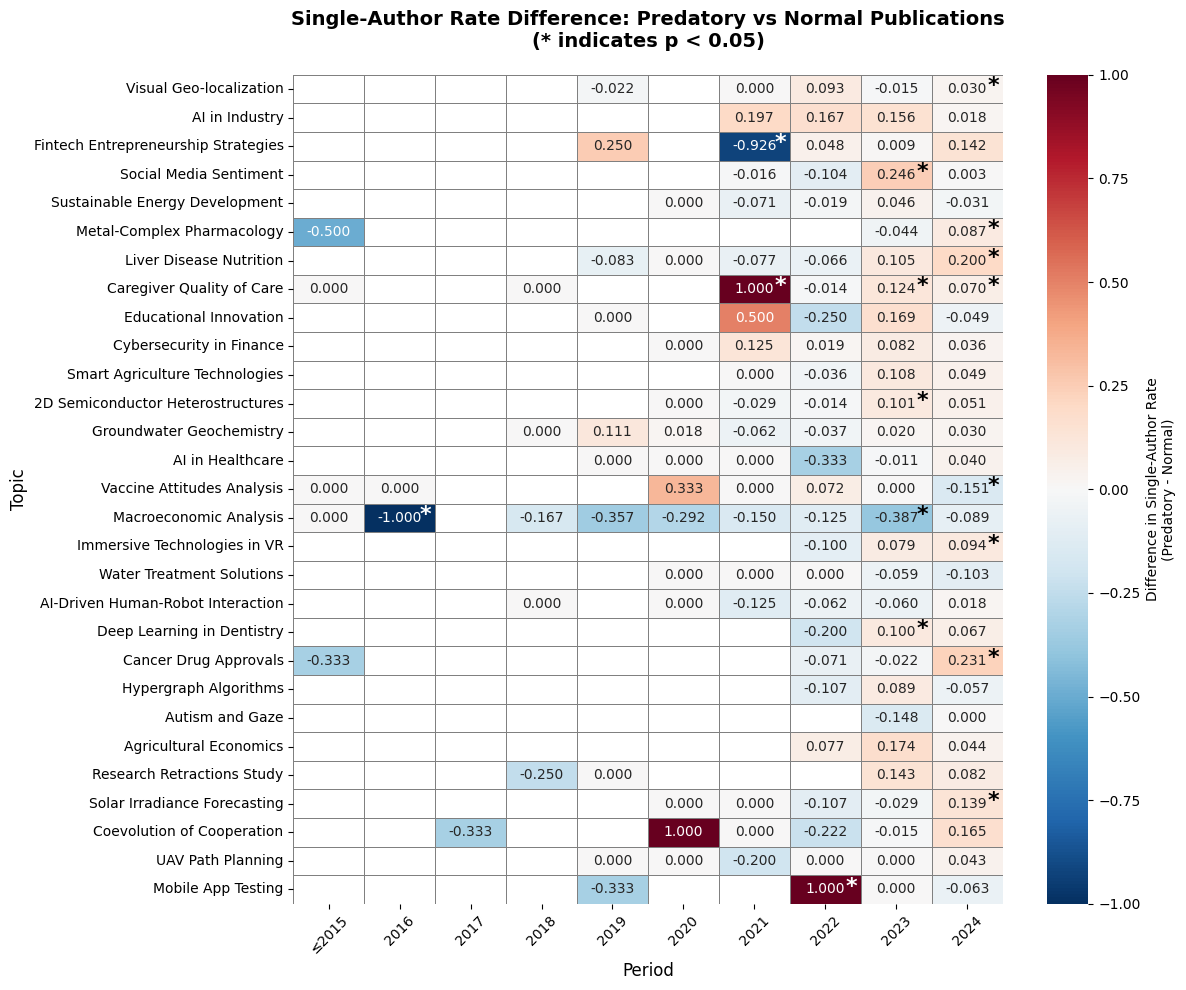


Difference Statistics:
Mean difference: -0.001
Max positive difference: 1.000
Max negative difference: -1.000
Proportion of significant differences: 5.86%


In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest

df = pd.merge(pred, norm, on=['topic', 'period'], how='outer').fillna(0)
records = []
for _, row in df.iterrows():
    n1, x1 = int(row['pred_total']), int(row['pred_single'])
    n2, x2 = int(row['norm_total']), int(row['norm_single'])
    p1 = x1 / n1 if n1 > 0 else np.nan
    p2 = x2 / n2 if n2 > 0 else np.nan
    
    is_significant = False
    if n1 > 0 and n2 > 0:
        # Two-sided test to check if proportions are significantly different
        _, p_val = proportions_ztest([x1, x2], [n1, n2], alternative='two-sided')
        if p_val < 0.05:
            is_significant = True
            
    records.append({
        'topic': row['topic'],
        'period': row['period'],
        'diff': p1 - p2,  # Predatory - Normal
        'is_significant': is_significant
    })
res = pd.DataFrame(records)

periods = ['≤2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023', '2024']
res = res[res['period'].isin(periods)]
pivot_diff = res.pivot(index='topic', columns='period', values='diff').reindex(columns=periods)
pivot_sig = res.pivot(index='topic', columns='period', values='is_significant').reindex(columns=periods).fillna(False).astype(bool)

pivot_diff.index = pivot_diff.index.astype(float)
pivot_sig.index = pivot_sig.index.astype(float)

for df_ in (pivot_diff, pivot_sig):
    df_.sort_index(inplace=True)

for df_ in [pivot_diff, pivot_sig]:
    df_.index = df_.index.map(lambda x: topic_map.get(x, f'Topic {int(x)}'))

fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(
    pivot_diff, 
    cmap='RdBu_r',  # Red for positive (Predatory > Normal), Blue for negative
    center=0,  
    annot=pivot_diff.round(3), 
    fmt='.3f',
    linewidths=0.5, 
    linecolor='gray',
    cbar_kws={'label': 'Difference in Single-Author Rate\n(Predatory - Normal)'},
    ax=ax
)

# Add significance stars
for i in range(pivot_diff.shape[0]):
    for j in range(pivot_diff.shape[1]):
        if pivot_sig.iat[i, j]:
            # Choose star color based on background intensity
            cell_value = pivot_diff.iat[i, j]
            star_color = 'white' if abs(cell_value) > 0.5 else 'black'
            ax.text(
                j + 0.95, i + 0.05,
                '*', ha='right', va='top', 
                color=star_color, fontsize=16, fontweight='bold'
            )

ax.set_ylabel('Topic', fontsize=12)
ax.set_xlabel('Period', fontsize=12)
ax.set_xticklabels(periods, rotation=45)
ax.set_title('Single-Author Rate Difference: Predatory vs Normal Publications\n(* indicates p < 0.05)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("figure/single_author_difference.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nDifference Statistics:")
print(f"Mean difference: {pivot_diff.values[~np.isnan(pivot_diff.values)].mean():.3f}")
print(f"Max positive difference: {np.nanmax(pivot_diff.values):.3f}")
print(f"Max negative difference: {np.nanmin(pivot_diff.values):.3f}")
print(f"Proportion of significant differences: {pivot_sig.sum().sum() / pivot_sig.size:.2%}")

<h1>Part 2: Duplicate Author Order</h1>

In [38]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_rel

PRE_END  = 2021          
POST_BEG, POST_END = 2022, 2024 

def yearly_duplicate_ratio(path):
    df = base_df(path).copy() 
    out = []
    for yr, group in df.groupby('year'):
        total = len(group)
        multi = group[group['authors'].str.contains(',', na=False)]
        counts = multi['authors'].value_counts()
        dup = counts[counts > 1].sum() if not counts.empty else 0
        out.append({'year': yr, 'total_papers': int(total),
                    'dup_records': int(dup),
                    'dup_ratio': (dup/total) if total>0 else np.nan})
    return pd.DataFrame(out).sort_values('year')

def label_period(df):
    def _lab(y):
        if y <= PRE_END: return 'pre'
        if POST_BEG <= y <= POST_END: return 'post'
        return 'other'
    df = df.copy()
    df['period'] = df['year'].apply(_lab)
    return df

def cohen_h(p1, p2):
    return 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p2)))

def proportions_summary(df_bad, df_good, mask, title):
   
    sb = df_bad.loc[mask(df_bad)]
    sg = df_good.loc[mask(df_good)]

    count = [sb['dup_records'].sum(), sg['dup_records'].sum()]
    nobs  = [sb['total_papers'].sum(),  sg['total_papers'].sum()]

    if nobs[0] == 0 or nobs[1] == 0:
        print(f"=== {title} ===")
        print("Insufficient data, skip.\n")
        return

    zstat, pval = proportions_ztest(count, nobs, alternative='larger') 
    p_bad  = count[0] / nobs[0]
    p_good = count[1] / nobs[1]
    h = cohen_h(p_bad, p_good)

    print(f"=== {title} ===")
    print(f"Bad  dup ratio = {p_bad:.3%}  ( {count[0]}/{nobs[0]} )")
    print(f"Good dup ratio = {p_good:.3%}  ( {count[1]}/{nobs[1]} )")
    print(f"One-sided z = {zstat:.3f}, p = {pval:.3g}")
    print(f"Cohen's h = {h:.3f}\n")

def paired_t_by_period(df_bad, df_good, which_period, title):
   
    b = df_bad[(df_bad['period'] == which_period) & (df_bad['total_papers'] > 0)]
    g = df_good[(df_good['period'] == which_period) & (df_good['total_papers'] > 0)]
    yrs = sorted(set(b['year']).intersection(set(g['year'])))
    if not yrs:
        print(f"=== {title} ===")
        print("There is no year overlap in this period to match, skip. \n")
        return

    b2 = b.set_index('year').loc[yrs]
    g2 = g.set_index('year').loc[yrs]

    # 若存在 NaN（极少见），先丢弃
    rb = b2['dup_ratio'].astype(float)
    rg = g2['dup_ratio'].astype(float)
    mask = rb.notna() & rg.notna()
    rb = rb[mask]; rg = rg[mask]; yrs_used = [y for (y,m) in zip(yrs, mask) if m]

    if len(rb) < 2:
        print(f"=== {title} ===")
        print("There are too few years available for pairing in this period, skip\n")
        return

    t_stat, p_t = ttest_rel(rb, rg)
    diffs = rb - rg
    d_mean = diffs.mean()
    d_sd   = diffs.std(ddof=1)
    coh_d  = d_mean / d_sd if d_sd > 0 else np.nan

    print(f"=== {title} ===")
    print(f"Years used: {yrs_used}")
    print(f"Mean diff (bad−good) = {d_mean:.3f}")
    print(f"paired t = {t_stat:.3f}, p = {p_t:.3g}")
    print(f"Cohen's d (paired) = {coh_d:.3f}\n")

# --------------------
# 1) Read and calculate the annual percentage
# --------------------
good = yearly_duplicate_ratio(path_norm).rename(columns=lambda c: c + '_good' if c!='year' else c)
bad  = yearly_duplicate_ratio(path_pred ).rename(columns=lambda c: c + '_bad'  if c!='year' else c)

df = pd.merge(good, bad, on='year', how='inner')

# label data
good_l = label_period(good.rename(columns={
    'total_papers_good':'total_papers',
    'dup_records_good':'dup_records',
    'dup_ratio_good':'dup_ratio'
}))
bad_l  = label_period(bad.rename(columns={
    'total_papers_bad':'total_papers',
    'dup_records_bad':'dup_records',
    'dup_ratio_bad':'dup_ratio'
}))

# --------------------
# 2) Overall (non-stage) inspection
# --------------------
count_all = [df['dup_records_bad'].sum(), df['dup_records_good'].sum()]
nobs_all  = [df['total_papers_bad'].sum(),  df['total_papers_good'].sum()]
zstat, pval = proportions_ztest(count_all, nobs_all, alternative='larger')
p_bad_all  = count_all[0] / nobs_all[0]
p_good_all = count_all[1] / nobs_all[1]
cohens_h_all = cohen_h(p_bad_all, p_good_all)

print("=== Overall Proportion Test (All Years in common) ===")
print(f"Bad  dup ratio = {p_bad_all:.3%}  ( {count_all[0]}/{nobs_all[0]} )")
print(f"Good dup ratio = {p_good_all:.3%}  ( {count_all[1]}/{nobs_all[1]} )")
print(f"One-sided z = {zstat:.3f}, p = {pval:.3g}")
print(f"Cohen's h = {cohens_h_all:.3f}\n")

# Yearly paired t-test (all intersecting years)
rat_bad_all  = df['dup_ratio_bad']
rat_good_all = df['dup_ratio_good']
t_stat_all, p_t_all = ttest_rel(rat_bad_all, rat_good_all)
diffs_all = rat_bad_all - rat_good_all
d_mean_all = diffs_all.mean()
d_sd_all   = diffs_all.std(ddof=1)
cohens_d_all = d_mean_all / d_sd_all if d_sd_all > 0 else np.nan

print("=== Paired t-test on Yearly Dup Ratios (All Years in common) ===")
print(f"Mean diff (bad−good) = {d_mean_all:.3f}")
print(f"paired t = {t_stat_all:.3f}, p = {p_t_all:.3g}")
print(f"Cohen's d (paired) = {cohens_d_all:.3f}\n")

# --------------------
# 3) Stage: Pre/Post Overall Proportion Test
# --------------------
proportions_summary(bad_l, good_l, lambda d: d['period']=='pre',  "Pre-LLM Proportion Test (≤2021)")
proportions_summary(bad_l, good_l, lambda d: d['period']=='post', "Post-LLM Proportion Test (2022–2024)")

# --------------------
# 4) Periodization: Pre/Post Year Paired t-Test (dup_ratio)
#    Perform pairing only on intersecting years within this period
# --------------------
paired_t_by_period(bad_l, good_l, 'pre',  "Paired t-test on Yearly Dup Ratios — Pre-LLM (≤2021)")
paired_t_by_period(bad_l, good_l, 'post', "Paired t-test on Yearly Dup Ratios — Post-LLM (2022–2024)")

# --------------------
# 5) 
#   Δ_bad = (post_dup/post_total) - (pre_dup/pre_total)
#   Δ_good = (post_dup/post_total) - (pre_dup/post_total)
#   DiD = Δ_bad - Δ_good  
# --------------------
def agg_ratio(d, period):
    sub = d[d['period']==period]
    num = sub['dup_records'].sum()
    den = sub['total_papers'].sum()
    return (num/den) if den>0 else np.nan, num, den

pre_b,  pre_b_num,  pre_b_den  = agg_ratio(bad_l,  'pre')
post_b, post_b_num, post_b_den = agg_ratio(bad_l,  'post')
pre_g,  pre_g_num,  pre_g_den  = agg_ratio(good_l, 'pre')
post_g, post_g_num, post_g_den = agg_ratio(good_l, 'post')

delta_b = post_b - pre_b if pd.notna(post_b) and pd.notna(pre_b) else np.nan
delta_g = post_g - pre_g if pd.notna(post_g) and pd.notna(pre_g) else np.nan
did = (delta_b - delta_g) if pd.notna(delta_b) and pd.notna(delta_g) else np.nan

print("=== Descriptive DiD (aggregate proportions) ===")
print(f"Bad  Δ(post−pre) = {delta_b:.3%}  |  Good Δ(post−pre) = {delta_g:.3%}")
print(f"DiD = {did:.3%}  (no formal SE here; use as descriptive)\n")


=== Overall Proportion Test (All Years in common) ===
Bad  dup ratio = 13.725%  ( 794/5785 )
Good dup ratio = 2.365%  ( 146/6173 )
One-sided z = 23.067, p = 4.96e-118
Cohen's h = 0.450

=== Paired t-test on Yearly Dup Ratios (All Years in common) ===
Mean diff (bad−good) = 0.015
paired t = 1.502, p = 0.149
Cohen's d (paired) = 0.328

=== Pre-LLM Proportion Test (≤2021) ===
Bad  dup ratio = 5.034%  ( 22/437 )
Good dup ratio = 3.310%  ( 28/846 )
One-sided z = 1.513, p = 0.0652
Cohen's h = 0.087

=== Post-LLM Proportion Test (2022–2024) ===
Bad  dup ratio = 14.433%  ( 772/5349 )
Good dup ratio = 2.400%  ( 118/4916 )
One-sided z = 21.642, p = 3.65e-104
Cohen's h = 0.468

=== Paired t-test on Yearly Dup Ratios — Pre-LLM (≤2021) ===
Years used: [1993, 2003, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Mean diff (bad−good) = 0.006
paired t = 0.678, p = 0.508
Cohen's d (paired) = 0.164

=== Paired t-test on Yearly Dup Ratios — Post-LLM (2022–2024) =

Stratified by topic and year

In [32]:
import pandas as pd
import numpy as np
import math
from statsmodels.stats.proportion import proportions_ztest

def compute_topic_period_stats(path):
    df = pd.read_csv(path, encoding='latin1')

    # Discard rows where topic_title_abs_30 is empty or a non-string
    df = df[df['topic_title_abs_30'].notna()]
    df['topic_title_abs_30'] = df['topic_title_abs_30'].astype(str).str.strip()
    df = df[df['topic_title_abs_30'] != '']  

    df['year'] = (
        df['publication_date'].astype(str)
          .str.extract(r'(\d{4})', expand=False)
          .dropna().astype(int)
    )
    df['period'] = df['year'].map(map_period).astype(str)
    df = df[df['period'] != 'None']  

    recs = []
    for (topic, period), g in df.groupby(['topic_title_abs_30', 'period']):
        total   = len(g)
        multi   = g[g['authors'].str.contains(',', na=False)]
        counts  = multi['authors'].value_counts()
        dup_rec = counts[counts > 1].sum()
        recs.append({
            'topic':      topic,
            'period':     period,
            'total':      total,
            'dup_rec':    dup_rec,
            'dup_ratio':  dup_rec / total
        })
    return pd.DataFrame(recs)
# 1. Calculate topic-period stats for Predatory and Regular
pred_stats = compute_topic_period_stats(path_pred).rename(
    columns=lambda c: c if c in ['topic','period'] else 'pred_' + c
)
norm_stats = compute_topic_period_stats(path_norm).rename(
    columns=lambda c: c if c in ['topic','period'] else 'norm_' + c
)


# Merge
df = pd.merge(pred_stats, norm_stats, on=['topic','period'], how='outer').fillna(0)

# Calculate ratios and tests
results = []
for _, row in df.iterrows():
    x1, n1 = int(row.get('pred_dup_rec', 0)), int(row.get('pred_total', 0))
    x2, n2 = int(row.get('norm_dup_rec', 0)), int(row.get('norm_total', 0))
    p1 = x1 / n1 if n1 > 0 else np.nan
    p2 = x2 / n2 if n2 > 0 else np.nan
    if n1 > 0 and n2 > 0:
        zstat, pval = proportions_ztest([x1, x2], [n1, n2], alternative='larger')
        coh_h = 2 * (math.asin(math.sqrt(p1)) - math.asin(math.sqrt(p2)))
    else:
        zstat, pval, coh_h = np.nan, np.nan, np.nan
    results.append({
        'topic': row['topic'],
        'period': row['period'],
        'pred_ratio': p1,
        'norm_ratio': p2,
        'z_stat': zstat,
        'p_value': pval,
        "Cohen's h": coh_h
    })

res_df = pd.DataFrame(results)
res_df['period'] = res_df['period'].astype(str).str.replace('.0', '', regex=False)

res_df.to_csv('data/topic_period_dup_order_stats.csv', index=False, encoding='utf-8')

print(res_df.sort_values(['topic','period']).to_string(index=False, float_format='%.3f'))



topic period  pred_ratio  norm_ratio  z_stat  p_value  Cohen's h
 -1.0   2019       0.000         NaN     NaN      NaN        NaN
 -1.0   2020       0.000         NaN     NaN      NaN        NaN
 -1.0   2021       0.000       0.000     NaN      NaN      0.000
 -1.0   2022       0.000       0.000     NaN      NaN      0.000
 -1.0   2023       0.000       0.154  -1.234    0.891     -0.806
 -1.0   2024       0.000       0.000     NaN      NaN      0.000
 -1.0  ≤2015       0.000         NaN     NaN      NaN        NaN
  0.0   2016         NaN       0.000     NaN      NaN        NaN
  0.0   2017         NaN       0.000     NaN      NaN        NaN
  0.0   2018         NaN       0.087     NaN      NaN        NaN
  0.0   2019       0.000       0.000     NaN      NaN      0.000
  0.0   2020         NaN       0.000     NaN      NaN        NaN
  0.0   2021       0.000       0.000     NaN      NaN      0.000
  0.0   2022       0.000       0.000     NaN      NaN      0.000
  0.0   2023       0.000 

/home/yuying/miniconda3/envs/new_scholar/lib/python3.9/site-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning: invalid value encountered in scalar divide
  zstat = value / std


/tmp/ipykernel_347796/850505008.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_sig  = res.pivot(index='topic', columns='period', values='sig').fillna(False).astype(bool)
/tmp/ipykernel_347796/850505008.py:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.96])


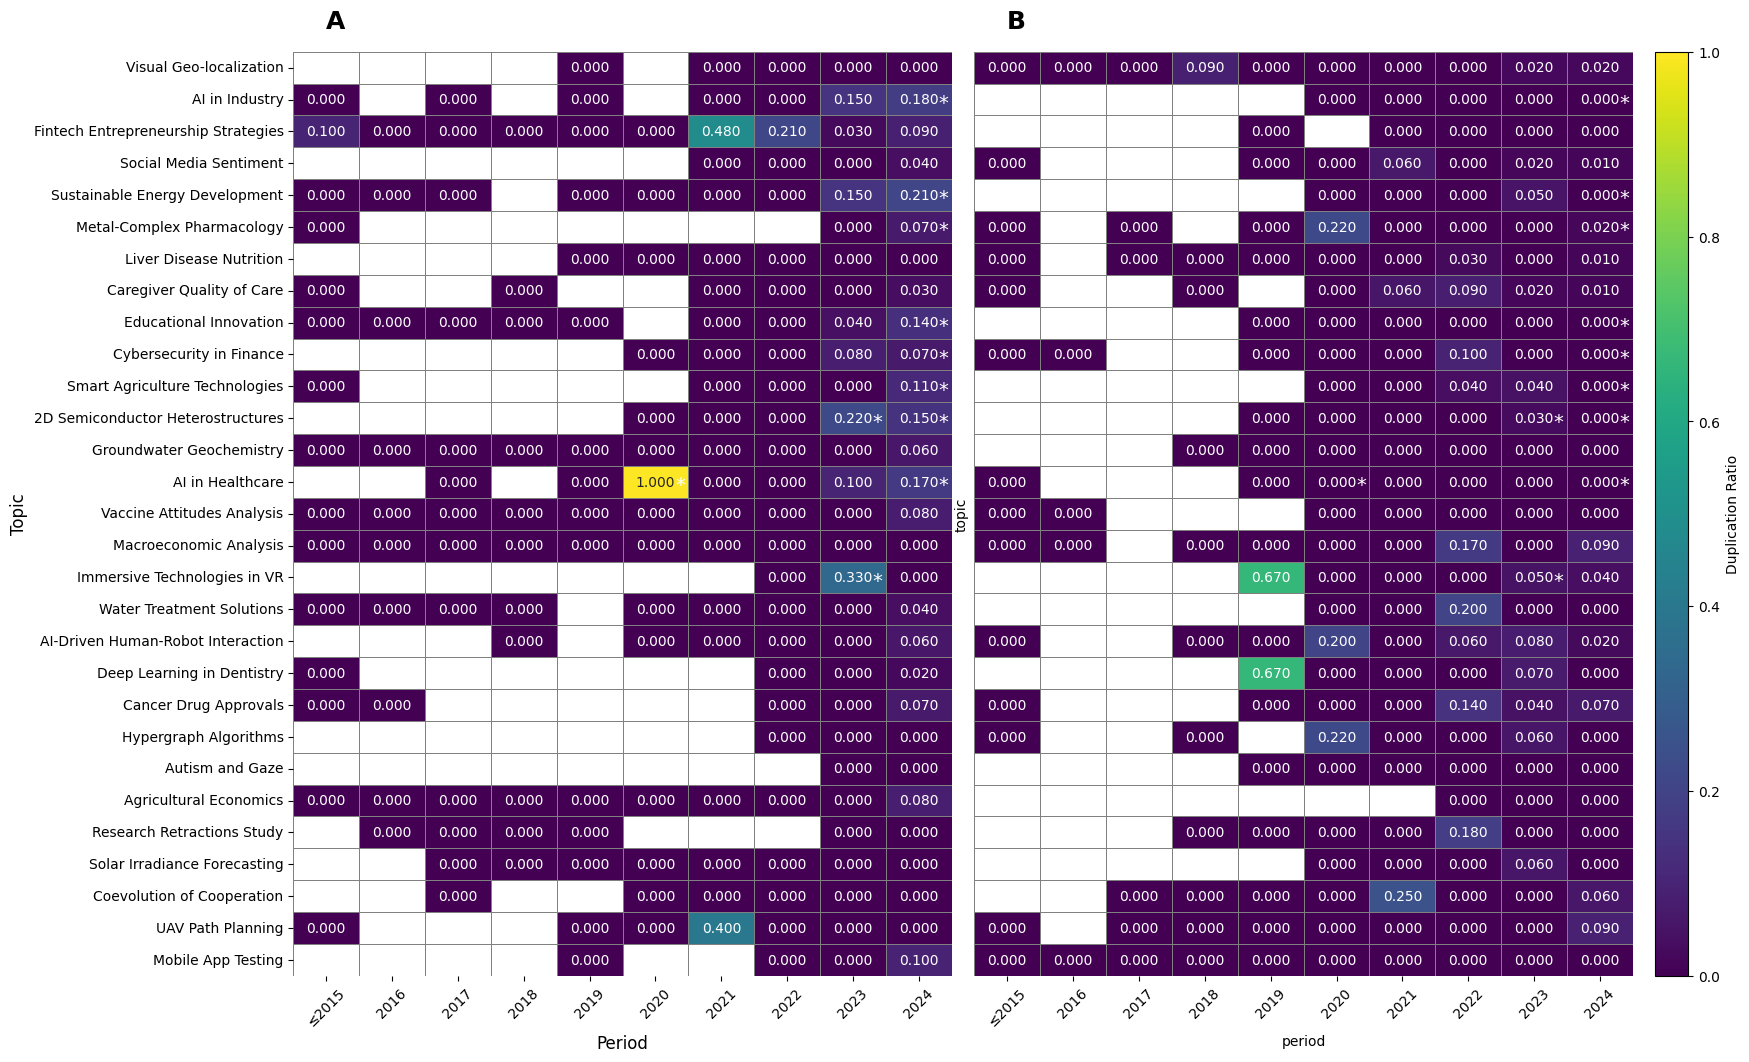

<Figure size 640x480 with 0 Axes>

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

res = pd.read_csv('data/topic_period_dup_order_stats.csv')
res = res[res['topic'].ne(-1.0)] 
periods = ['≤2015','2016','2017','2018','2019','2020','2021','2022','2023','2024']
res = res[res['period'].isin(periods)].copy()
res['sig'] = res['p_value'] < 0.05

pivot_pred = res.pivot(index='topic', columns='period', values='pred_ratio')
pivot_norm = res.pivot(index='topic', columns='period', values='norm_ratio')
pivot_sig  = res.pivot(index='topic', columns='period', values='sig').fillna(False).astype(bool)
pivot_diff = pivot_pred - pivot_norm

# convert topic to integer
for df in (pivot_pred, pivot_norm, pivot_diff, pivot_sig):
    df.index = df.index.astype(int)
pivot_pred = pivot_pred.sort_index()
pivot_norm = pivot_norm.sort_index()
pivot_diff = pivot_diff.sort_index()
pivot_sig  = pivot_sig.sort_index()

pivot_pred = pivot_pred[periods]
pivot_norm = pivot_norm[periods]
pivot_diff = pivot_diff[periods]
pivot_sig  = pivot_sig[periods]

vmin, vmax = 0, 1
diff_vmax = np.nanmax(np.abs(pivot_diff.values))

for df_ in (pivot_pred, pivot_norm, pivot_diff, pivot_sig):
    df_.index = df_.index.map(lambda x: topic_map.get(x, f'Topic {int(x)}'))

fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.05)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)

cbar_ax = fig.add_subplot(gs[0, 2])

cmap = 'viridis'

# A：Predatory
hm_a = sns.heatmap(
    pivot_pred, cmap=cmap, vmin=vmin, vmax=vmax,
    annot=pivot_pred.round(2), fmt='.3f',
    linewidths=0.5, linecolor='gray',
    cbar=False, ax=ax1
)
ax1.set_ylabel('Topic', fontsize=12)
ax1.set_xlabel('Period', fontsize=12)
ax1.set_xticklabels(pivot_pred.columns, rotation=45)
# ax1.set_title('Predatory Author Order Duplication Rate', fontsize=12)
ax1.text(0.05, 1.02, 'A', transform=ax1.transAxes, fontsize=18, fontweight='bold', ha='left', va='bottom')

for i in range(pivot_pred.shape[0]):
    for j in range(pivot_pred.shape[1]):
        if pivot_sig.iat[i, j]:
            ax1.text(j + 0.95, i + 0.3, '*', ha='right', va='top', color='white', fontsize=14)

# B：Regular
hm_b = sns.heatmap(
    pivot_norm, cmap=cmap, vmin=vmin, vmax=vmax,
    annot=pivot_norm.round(2), fmt='.3f',
    linewidths=0.5, linecolor='gray',
    cbar=False, ax=ax2
)
# ax2.set_xlabel('Period', fontsize=12)
ax2.set_xticklabels(pivot_norm.columns, rotation=45)
# ax2.set_title('Regular Author Order Duplication Rate', fontsize=12)
ax2.tick_params(axis='y', labelleft=False, left=False)
ax2.text(0.05, 1.02, 'B', transform=ax2.transAxes, fontsize=18, fontweight='bold', ha='left', va='bottom')

for i in range(pivot_norm.shape[0]):
    for j in range(pivot_norm.shape[1]):
        if pivot_sig.iat[i, j]:
            ax2.text(j + 0.95, i + 0.3, '*', ha='right', va='top', color='white', fontsize=14)

fig.colorbar(hm_b.collections[0], cax=cbar_ax, label='Duplication Ratio')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
plt.savefig("figure/author_dupli_year_topic.png",dpi=300)

Single difference heatmap

/tmp/ipykernel_347796/12766301.py:8: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pivot_sig = res.pivot(index='topic', columns='period', values='sig').fillna(False).astype(bool)


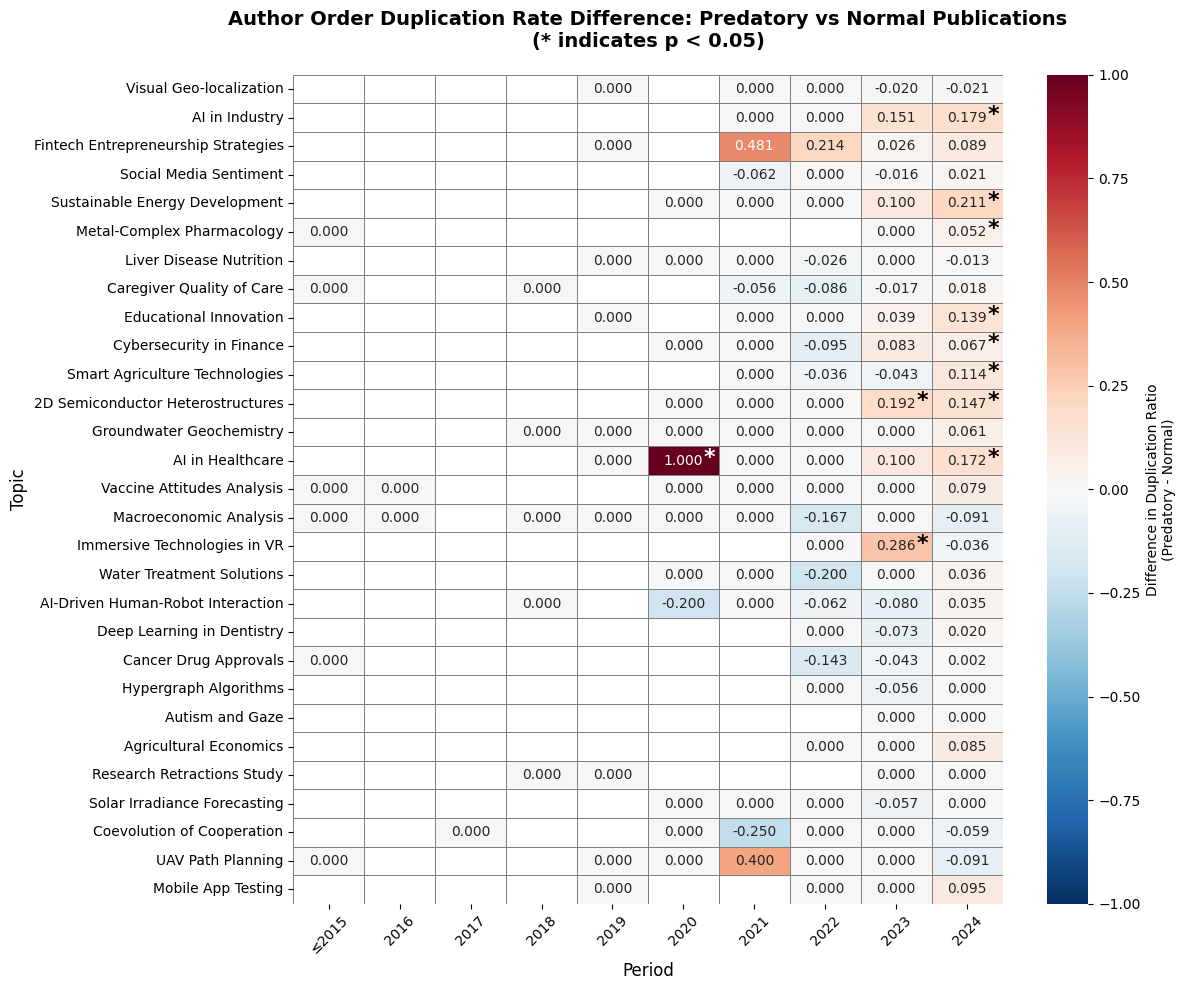


Difference Statistics:
Mean difference: 0.018
Max positive difference: 1.000
Max negative difference: -0.250
Proportion of significant differences: 3.79%

Number of significant cells: 11 out of 290 total cells


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pivot_pred = res.pivot(index='topic', columns='period', values='pred_ratio')
pivot_norm = res.pivot(index='topic', columns='period', values='norm_ratio')
pivot_sig = res.pivot(index='topic', columns='period', values='sig').fillna(False).astype(bool)
pivot_diff = pivot_pred - pivot_norm

# Convert topic to integer 
for df in (pivot_pred, pivot_norm, pivot_diff, pivot_sig):
    df.index = df.index.astype(int)
pivot_pred = pivot_pred.sort_index()
pivot_norm = pivot_norm.sort_index()
pivot_diff = pivot_diff.sort_index()
pivot_sig = pivot_sig.sort_index()

pivot_pred = pivot_pred[periods]
pivot_norm = pivot_norm[periods]
pivot_diff = pivot_diff[periods]
pivot_sig = pivot_sig[periods]

for df_ in (pivot_pred, pivot_norm, pivot_diff, pivot_sig):
    df_.index = df_.index.map(lambda x: topic_map.get(x, f'Topic {int(x)}'))

fig, ax = plt.subplots(figsize=(12, 10))

max_abs_diff = np.nanmax(np.abs(pivot_diff.values))
vmin_diff = -max_abs_diff
vmax_diff = max_abs_diff

sns.heatmap(
    pivot_diff,
    cmap='RdBu_r',  
    center=0,  
    vmin=vmin_diff,  
    vmax=vmax_diff,  
    annot=pivot_diff.round(3),
    fmt='.3f',
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Difference in Duplication Ratio\n(Predatory - Normal)'},
    ax=ax
)

for i in range(pivot_diff.shape[0]):
    for j in range(pivot_diff.shape[1]):
        if pivot_sig.iat[i, j]:
            cell_value = pivot_diff.iat[i, j]
            star_color = 'white' if abs(cell_value) > 0.5 else 'black'
            ax.text(
                j + 0.95, i + 0.05,
                '*', ha='right', va='top',
                color=star_color, fontsize=16, fontweight='bold'
            )

ax.set_ylabel('Topic', fontsize=12)
ax.set_xlabel('Period', fontsize=12)
ax.set_xticklabels(periods, rotation=45)
ax.set_title('Author Order Duplication Rate Difference: Predatory vs Normal Publications\n(* indicates p < 0.05)',
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig("figure/author_dupli_difference.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nDifference Statistics:")
print(f"Mean difference: {pivot_diff.values[~np.isnan(pivot_diff.values)].mean():.3f}")
print(f"Max positive difference: {np.nanmax(pivot_diff.values):.3f}")
print(f"Max negative difference: {np.nanmin(pivot_diff.values):.3f}")
print(f"Proportion of significant differences: {pivot_sig.sum().sum() / pivot_sig.size:.2%}")
print(f"\nNumber of significant cells: {pivot_sig.sum().sum()} out of {pivot_sig.size} total cells")